In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
X_train_raw = pd.read_csv('/content/drive/MyDrive/rainfall_csv_kaggle/train.csv', index_col='id').copy()
target = 'rainfall'
y_train = X_train_raw.pop(target)

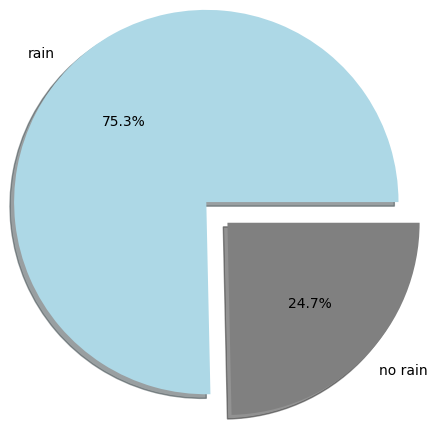

In [40]:
y_train.value_counts().plot.pie(labels=['rain', 'no rain'], autopct='%1.1f%%', shadow=True,
                                       explode=[0.1, 0.1], colors=['lightblue', 'grey'], radius=1.3)
plt.ylabel('');

In [41]:
X_test_raw = pd.read_csv('/content/drive/MyDrive/rainfall_csv_kaggle/test.csv', index_col='id')
X_test_raw_ = X_test_raw.ffill()
sub_file = pd.read_csv('/content/drive/MyDrive/rainfall_csv_kaggle/sample_submission.csv')

In [42]:
X_orig_raw = pd.read_csv('/content/drive/MyDrive/Rainfall.csv').copy()
y_orig = X_orig_raw.pop(target)

# Remove empty spaces from the features names in original dataset
X_orig_raw.columns = X_orig_raw.columns.str.replace(' ', '')

# Reorder the features in original dataset to match that of competition
X_orig_raw = X_orig_raw[X_train_raw.columns].copy()

# Binarize the target in the original dataset
y_orig = y_orig == 'yes'
# y_orig = y_orig.map({'no': 0, 'yes': 1})

# fill the missing values in test and original datasets
X_orig_raw = X_orig_raw.ffill()

display(X_orig_raw.head(2))

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,0.6,50.0,15.3


In [43]:
# Decide if features should be engineered
feat_eng = True

def df_processing(df):
    if feat_eng:
        df['pressure'] = df['pressure'] - 1000
        df['temp_gap'] = df['maxtemp'] - df['mintemp']
        df['temp_to_gap_ratio'] = df['temparature']*df['temp_gap']
        for feat in ['temparature', 'dewpoint', 'humidity', 'pressure',
                     'cloud', 'sunshine', 'windspeed', 'winddirection']:
            df[f'{feat}_previous_day'] = df[feat].shift(1).fillna(0)
            df[f'{feat}_next_day'] = df[feat].shift(-1).fillna(0)
            df[f'{feat}_change_overnight'] = df[feat] - df[f'{feat}_previous_day']
        # # # others
        df['dew_humidity'] = df['dewpoint']*df['humidity']
        df['wind_speeddirection'] = df['windspeed']*df['winddirection']
        df['cloud_windspeed'] = df['cloud']*df['windspeed']
        df['cloud_to_humidity'] = df['cloud']/df['humidity']
        df['temp_to_humidity'] = df['cloud']/df['humidity']
        df['temp_to_sunshine'] = df['sunshine']/df['temparature']
        # df['month'] = pd.cut(df['day'], bins=12, labels=range(1, 13)).astype('int')
        # # df['exp_sunshine'] = np.exp(df['sunshine'])
        # df['log_day'] = np.log(df['day'])
        df['sin_day'] = np.sin(df['day'])
        df['wind_deg'] = np.deg2rad(df['winddirection'])
        df['sin_winddirection'] = np.sin(2*np.pi*df['winddirection'])
        df['tan_winddirection'] = np.tan(2*np.pi*df['winddirection'])
        # df['day_bins'] = pd.cut(df['day'], bins=12).astype('int')
        df['expected_day'] = df.index%365 + 1
        df['cloudtest_88'] =  (df.cloud==88).astype(int)
        df['cloudtest_90'] =  (df.cloud>90).astype(int)
        try:
            df['tan_day'] = np.tan(2*np.pi*df['expected_day']/365)
            df['month'] = pd.cut(df['expected_day'], bins=12, labels=range(1,13)).astype('int')
            df['sin_day']=np.sin(2*np.pi*df['expected_day']/365)
            df['cos_day2']=np.cos(2*np.pi*df['expected_day']/365/2)
            df['cos_winddirection'] = np.cos(2*np.pi*df['winddirection'])

            pass
        except:
            pass

      #  df = df.drop(columns=['maxtemp', 'mintemp', 'dewpoint'])
    else:
        df = df

    X = df.copy()
    return X


In [44]:
X_comb_raw = pd.concat([X_train_raw, X_orig_raw], ignore_index=False)
X_comb_raw

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8
...,...,...,...,...,...,...,...,...,...,...,...
361,27,1022.7,18.8,17.7,16.9,15.0,84.0,90.0,0.0,30.0,18.4
362,28,1026.6,18.6,17.3,16.3,12.8,75.0,85.0,1.0,20.0,25.9
363,29,1025.9,18.9,17.7,16.4,13.3,75.0,78.0,4.6,70.0,33.4
364,30,1025.3,19.2,17.3,15.2,13.3,78.0,86.0,1.2,20.0,20.9


In [45]:
X_train = df_processing(X_train_raw)
X_test = df_processing(X_test_raw_)
X_orig = df_processing(X_orig_raw)
X_comb = df_processing(X_comb_raw)

In [46]:
scaler = MinMaxScaler()

column_trans = make_column_transformer(
    # (OneHotEncoder(), X_train.select_dtypes('object').columns.tolist()),
    (scaler, X_train.select_dtypes('number').columns),
    remainder='passthrough',
    sparse_threshold=0)

In [47]:
y_comb = pd.concat([y_train, y_orig], ignore_index=True)

In [48]:
X_train_ = column_trans.fit_transform(X_train)
X_test_ = column_trans.transform(X_test)
X_orig_ = column_trans.transform(X_orig)
X_comb_ = column_trans.transform(X_comb)

In [49]:
X_train_

array([[0.00000000e+00, 5.16853933e-01, 4.21875000e-01, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.74725275e-03, 5.75842697e-01, 2.26562500e-01, ...,
        0.00000000e+00, 9.99944439e-01, 1.00000000e+00],
       [5.49450549e-03, 7.05056180e-01, 3.51562500e-01, ...,
        0.00000000e+00, 9.99851842e-01, 1.00000000e+00],
       ...,
       [9.94505495e-01, 4.01685393e-01, 3.35937500e-01, ...,
        1.00000000e+00, 7.40817675e-05, 1.00000000e+00],
       [9.97252747e-01, 6.54494382e-01, 2.34375000e-01, ...,
        1.00000000e+00, 1.85207849e-05, 1.00000000e+00],
       [1.00000000e+00, 4.15730337e-01, 4.21875000e-01, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [50]:
X_test_

array([[0.00000000e+00, 5.75842697e-01, 2.77343750e-01, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.74725275e-03, 4.91573034e-01, 2.77343750e-01, ...,
        0.00000000e+00, 9.99944439e-01, 1.00000000e+00],
       [5.49450549e-03, 6.99438202e-01, 3.12500000e-02, ...,
        0.00000000e+00, 9.99851842e-01, 1.00000000e+00],
       ...,
       [9.94505495e-01, 6.65730337e-01, 4.14062500e-01, ...,
        1.00000000e+00, 7.40817675e-05, 1.00000000e+00],
       [9.97252747e-01, 4.32584270e-01, 4.14062500e-01, ...,
        1.00000000e+00, 1.85207849e-05, 1.00000000e+00],
       [1.00000000e+00, 6.15168539e-01, 4.60937500e-01, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [51]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.metrics import AUC
from sklearn.metrics import auc

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC

import warnings
warnings.filterwarnings('ignore')

In [52]:
X_train = X_train_.reshape((X_train_.shape[0], X_train_.shape[1], 1))
# X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test_.reshape((X_test_.shape[0], X_test_.shape[1], 1))

In [53]:
decision_fnc = 'sigmoid'

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 52, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 26, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 24, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 10, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,953 (85.75 KB)

 Trainable params: 21,953 (85.75 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# # Compile the model with AUC metric
# model.compile(
#     optimizer=Adam(learning_rate=0.001),  # Or tf.keras.optimizers.Adam(learning_rate=0.001)
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy', AUC(name='roc_auc')]  # Adding AUC metric as 'roc_auc'
# )is

In [55]:
model.compile(optimizer= SGD(learning_rate=0.05),
              loss='binary_crossentropy',
              metrics=[AUC(name='auc')])

my_callback = keras.callbacks.EarlyStopping(monitor='auc',min_delta=0.01,patience=5,
                                            verbose=0,mode='max',baseline=None,
                                            restore_best_weights=True,start_from_epoch=30)

In [56]:
include_orig_data = False
if include_orig_data:
    X, y = X_comb, y_comb
else:
    X, y = X_train, y_train

In [57]:
history = model.fit(X, y, epochs=350, validation_split=1/6, callbacks=[my_callback], shuffle=False)

Epoch 1/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - auc: 0.4898 - loss: 0.6129 - val_auc: 0.7335 - val_loss: 0.5139
Epoch 2/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.5370 - loss: 0.5671 - val_auc: 0.8030 - val_loss: 0.5104
Epoch 3/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.5753 - loss: 0.5627 - val_auc: 0.8450 - val_loss: 0.5052
Epoch 4/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.6178 - loss: 0.5561 - val_auc: 0.8540 - val_loss: 0.4996
Epoch 5/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.6675 - loss: 0.5486 - val_auc: 0.8615 - val_loss: 0.4902
Epoch 6/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.7170 - loss: 0.5365 - val_auc: 0.8653 - val_loss: 0.4695
Epoch 7/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.7857 - loss: 0.5115 - val_auc: 0.8650 - val_loss: 0.4414
Epoch 8/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8335 - loss: 0.4740 - val_auc: 0.8670 - val_loss: 0.3922
Epoch 9/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.853

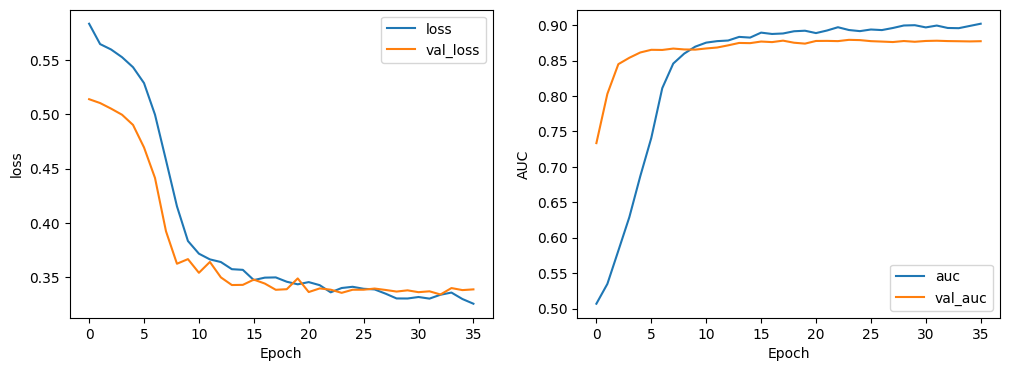

In [63]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label = 'val_auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')

plt.show()

In [59]:
# roc_auc_score(y_orig, model.predict(X_orig))

In [60]:
pred_proba = model.predict(X_test)

sub_file[target] = pred_proba

sub_file.to_csv('submission.csv', index=False)
print('The file is ready for submission!')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
The file is ready for submission!


In [61]:
sub_file.head(10)

,id,rainfall
0,2190,0.881896
1,2191,0.985496
2,2192,0.919215
3,2193,0.127161
4,2194,0.140483
5,2195,0.904200
6,2196,0.941632
7,2197,0.964907
8,2198,0.944980
9,2199,0.902749


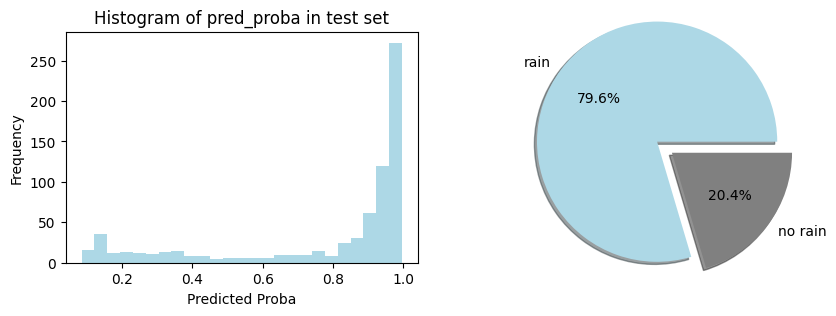

In [62]:
plt.subplot(121)
sub_file.rainfall.plot.hist(bins=25, color='lightblue', figsize=(10, 3),
                          title='Histogram of pred_proba in test set')
plt.xlabel('Predicted Proba')
plt.subplot(122)
(sub_file > 0.5).value_counts().plot.pie(labels=['rain', 'no rain'], autopct='%1.1f%%', shadow=True,
                                       explode=[0.1, 0.1], colors=['lightblue', 'grey'], radius=1.3)
plt.ylabel('');